In [ ]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#33ccff'

In [ ]:
style.set_style()

# load results from a directory

In [ ]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
fnames = sorted([fname for fname in os.listdir(out_dir) 
                 if not fname.startswith('weights')
                 and if not fname.startswith('idx')])
#                  if not 'mnist' in fname and 
#                  'numlays=4' in fname and 
#                  'batchsize=100' in fname and not 'batchsize=1000' in fname])
#                   and 
#                  'numlays=4' in fname]) # and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
# weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
#                 if fname.startswith('weights')]
# results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

save_dir = 'results_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# print('loaded', results_weights.shape[0], 'runs')

# add cols

In [ ]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
results = process_results(results)

In [ ]:
results.shape

# plot max corrs
*note some things disappear in below plot as a result of nans*

In [ ]:
r = results[(results.seed == 0) * (results.shuffle_labels == False)]
# r = results[results.num_layers == 4]
hue = 'batch_size'

plt.figure(figsize=(10, 10))
R, C = 2, 2
rm = r[r.dset == 'mnist']
plt.subplot(R, C, 1)
plt.title('mnist')

sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue])
plt.ylim(0, 1)

plt.subplot(R, C, 2)
plt.title('mnist')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)


rm = r[r.dset == 'cifar10']
plt.subplot(R, C, 3)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue])
plt.ylim(0, 1)

plt.subplot(R, C, 4)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)

# track things over time

In [ ]:
rm = results[(results.dset == 'mnist') * (results.max_test_acc >= 0.9) * (results.seed==0)] # good mnist
# rm = results[(results.dset == 'mnist') * (results.max_test_acc < 0.9) * (results.seed==0)] # bad mnist
# rm = results[(results.dset == 'cifar10') * (results.max_test_acc >= 0.4) * (results.seed==0)] # good cifar10
# rm = results[(results.dset == 'cifar10') * (results.max_test_acc < 0.4) * (results.seed==0)] # good cifar10

rm = rm[rm.shuffle_labels == False]

R, C = 2, 5
plt.figure(figsize=(15, 8))
xlim = 100

vals = ['accs_train', 'accs_test', 'corr0', 'corr1', 'fc0_fro', 'fc1_fro', 'fc0_stab_rank', 'fc1_stab_rank', 'act0_stab_rank', 'act1_stab_rank']


# well-behaved
for _, row in rm.iterrows():

    for i, val in enumerate(vals):
        plt.subplot(R, C, i+1)
        try:
            plt.plot(ts, row[val], color='red' if row.optimizer=='adam' else cb, alpha=0.5)
        except:
            plt.plot(row.its[:row[val].size], row[val], color='red' if row.optimizer=='adam' else cb, alpha=0.5)
        plt.xlabel('epochs')
        plt.ylabel(val)
        plt.xlim((0, xlim))

## plot these things against one another
**overmemorization in the beginning can still maintain high train acc but suffers on test acc**

In [ ]:
rm = results[(results.seed == 0) * (results.dset == 'mnist')]
# rm = results[(results.dset == 'mnist') * (results.max_test_acc >= 0.8)]
plt.figure(figsize=(12, 4))
R, C = 1, 1
for _, row in rm.iterrows():

    plt.subplot(R, C, 1)
    idxs = [True if v in ts else False for v in row.its[:row.accs_train.size]]
    accs_train = row.accs_train[idxs]
    plt.plot(accs_train, row.corr0, color='red' if row.optimizer=='adam' else cb, alpha=0.1)
#     plt.scatter(accs_train, row.corr0, c=accs_train) #color='red' if row.optimizer=='adam' else cb, alpha=0.1)    
#     plt.plot([accs_train[0], accs_train[1], accs_train[-1]], [row.corr0[0], row.corr0[1], row.corr0[-1]]) #, color='red' if row.optimizer=='adam' else cb, alpha=0.1)    
#     plt.plot([accs_train[3], accs_train[-1]], [row.corr0[3], row.corr0[-1]], alpha=0.5) #, color='red' if row.optimizer=='adam' else cb, alpha=0.1)        
    plt.xlabel('train acc')
    plt.ylabel('max_corr')
    
    '''
    
    plt.plot(row.its[:row.accs_train.size], row.accs_train, 
    plt.xlabel('epochs')
    plt.ylabel('max_corr')
    plt.xlim((0, 20))
    
    plt.subplot(R, C, 2)
    plt.title('max')
    
    plt.plot(ts, row.corr0, color='red' if row.optimizer=='adam' else cb, alpha=0.5)
    plt.xlabel('epochs')
    plt.ylabel('max_corr')
    plt.xlim((0, 20))
    '''
    

In [ ]:
np.unique(results.num_layers)
np.unique(results.optimizer, return_counts=True)

# stability over random init
**note there are some nans/infs here which are being ignored**

In [ ]:
chr(ord('A'))

In [1]:
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed
r = results[results.shuffle_labels == False]
r_mu = r.groupby(sweep_params).mean()
r_std = r.groupby(sweep_params).std()
r_snr = r_mu / r_std
r_mu = r_mu.reset_index()
r_std = r_std.reset_index()
# print(r_mu.describe())

R, C = 4, 4
vals = ['max_train_acc', 'max_test_acc', 'corr0_final', 'corr1_final', 
        'fc0_fro_final', 'fc1_fro_final', 'fc0_stab_rank_final', 'fc1_stab_rank_final', 'act0_stab_rank_final', 'act1_stab_rank_final']
val_labs = ['Train Acc', 'Test Acc', '$\\rho_{mem}(W_1)$', '$\\rho_{mem}(W_2)$', 
        '$||W_1||_F$', '$||W_2||_F$', 'Stable rank($||W_1||$)', 'Stable rank($||W_2||$)', 'Stable rank($||A_1||$)', 'Stable rank($||A_2||$)']

plt.figure(figsize=(14, 20), dpi=100)
for i, val in enumerate(vals):
    plt.subplot(R, C, i + 1)
    plt.title(val_labs[i])
    plt.title(chr(ord('A') + i), loc='left', fontweight='bold')
    sns.scatterplot(r_mu[val], r_std[val], legend=None, alpha=0.5) # hue=r_mu['optimizer'], 

    # print diag line
    left, right = plt.xlim()  # return the current xlim
    xspace = np.linspace(0, right, 100)
    plt.plot(xspace, xspace, '--', alpha=0.5, color='black')
    ymax = np.max(r_std[val])
    dy = ymax / 20
    plt.ylim(-dy, ymax + dy)
    plt.xlabel('Mean')
    plt.ylabel('S.D.')
plt.show()

NameError: name 'results' is not defined

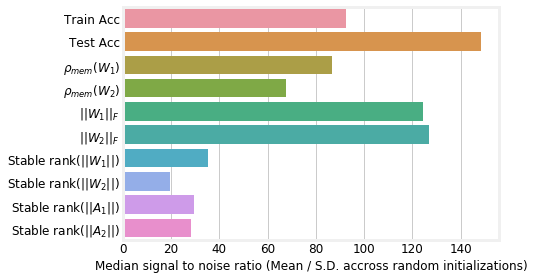

In [132]:
means = [] 
medians = []
# plt.figure(figsize=(4, 2), dpi=100)
for i, val in enumerate(vals):
    snr = r_snr[val].values
    snr = snr[np.isfinite(snr)]
    means.append(np.mean(snr))
    medians.append(np.median(snr))
# r_snr['max_train_acc']
# sns.barplot(x = means, y = vals, orient='h')

sns.barplot(x = medians, y = val_labs, orient='h')
plt.xlabel("Median signal to noise ratio (Mean / S.D. accross random initializations)")
plt.savefig('out.png', dpi=300)
plt.show()

In [ ]:
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed
r = results[results.shuffle_labels == False]
r_mu = r.groupby(sweep_params).mean()
r_std = r.groupby(sweep_params).std()
r_snr = r_mu / r_std
r_mu = r_mu.reset_index()
r_std = r_std.reset_index()
# print(r_mu.describe())

R, C = 4, 4
vals = ['max_train_acc', 'max_test_acc', 'corr0_final', 'corr1_final', 
        'fc0_fro_final', 'fc1_fro_final', 'fc0_stab_rank_final', 'fc1_stab_rank_final', 'act0_stab_rank_final', 'act1_stab_rank_final']
plt.figure(figsize=(12, 18), dpi=100)
for i, val in enumerate(vals):
    plt.subplot(R, C, i + 1)
    plt.title(val)
    snr = r_snr[val].values
    snr = snr[np.isfinite(snr)]
    plt.hist(snr)
plt.show()